In [1]:
import torch
import numpy as np

path = "./data/cora/"
cites = path + "cora.cites"
content = path + "cora.content"

# 索引字典，将原本的论文id转换到从0开始编码
index_dict = dict()
# 标签字典，将字符串标签转化为数值
label_to_index = dict()

features = []
labels = []
edge_index = []

with open(content,"r") as f:
    nodes = f.readlines()
    for node in nodes:
        node_info = node.split()
        index_dict[int(node_info[0])] = len(index_dict)
        features.append([int(i) for i in node_info[1:-1]])
        
        label_str = node_info[-1]
        if(label_str not in label_to_index.keys()):
            label_to_index[label_str] = len(label_to_index)
        labels.append(label_to_index[label_str])

with open(cites,"r") as f:
    edges = f.readlines()
    for edge in edges:
        start, end = edge.split()
        # 训练时将边视为无向的，但原本的边是有向的，因此需要正反添加两次
        edge_index.append([index_dict[int(start)],index_dict[int(end)]])
        edge_index.append([index_dict[int(end)],index_dict[int(start)]])

# 为每个节点增加自环，但后续GCN层默认会添加自环，跳过即可
# for i in range(2708):
#     edge_index.append([i,i])
  
# 转换为Tensor
labels = torch.LongTensor(labels)
features = torch.FloatTensor(features)
# 行归一化
# features = torch.nn.functional.normalize(features, p=1, dim=1)
edge_index =  torch.LongTensor(edge_index)

In [2]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv

class GCNNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GCNNet,self).__init__()
        self.GCN1 = GCNConv(num_feature, 16)
        self.GCN2 = GCNConv(16, num_label)  
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GCN1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.GCN2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

class GATNet(torch.nn.Module):
    def __init__(self, num_feature, num_label):
        super(GATNet,self).__init__()
        self.GAT1 = GATConv(num_feature, 8, heads = 8, concat = True, dropout = 0.6)
        self.GAT2 = GATConv(8*8, num_label, dropout = 0.6)  
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.GAT1(x, edge_index)
        x = F.relu(x)
        x = self.GAT2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

c:\Users\23231\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 2023
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  # Numpy module.
# random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
from torch_geometric.data import Data

mask = torch.randperm(len(index_dict))
train_mask = mask[:2400]
test_mask = mask[2400:]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cora = Data(x = features, edge_index = edge_index.t().contiguous(), y = labels).to(device)
print(cora)

cpu
Data(x=[2708, 1433], edge_index=[2, 10858], y=[2708])


In [5]:
model = GCNNet(features.shape[1], len(label_to_index)).to(device)
# model = GATNet(features.shape[1], len(label_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    out = model(cora)
    loss = F.nll_loss(out[train_mask], cora.y[train_mask])
    print('epoch: %d loss: %.4f' %(epoch, loss))
    loss.backward()
    optimizer.step()
    
    if((epoch + 1)% 10 == 0):
        model.eval()
        _, pred = model(cora).max(dim=1)
        correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
        acc = correct / len(test_mask)
        print('Accuracy: {:.4f}'.format(acc))
        model.train()

epoch: 0 loss: 1.9512
epoch: 1 loss: 1.8717
epoch: 2 loss: 1.7733
epoch: 3 loss: 1.6661
epoch: 4 loss: 1.5739
epoch: 5 loss: 1.4779
epoch: 6 loss: 1.3653
epoch: 7 loss: 1.2703
epoch: 8 loss: 1.2048
epoch: 9 loss: 1.1232
Accuracy: 0.7240
epoch: 10 loss: 1.0605
epoch: 11 loss: 0.9818
epoch: 12 loss: 0.9158
epoch: 13 loss: 0.8351
epoch: 14 loss: 0.7765
epoch: 15 loss: 0.7479
epoch: 16 loss: 0.6757
epoch: 17 loss: 0.6671
epoch: 18 loss: 0.6093
epoch: 19 loss: 0.5923
Accuracy: 0.8701
epoch: 20 loss: 0.5416
epoch: 21 loss: 0.5195
epoch: 22 loss: 0.5020
epoch: 23 loss: 0.4704
epoch: 24 loss: 0.4545
epoch: 25 loss: 0.4436
epoch: 26 loss: 0.4253
epoch: 27 loss: 0.4111
epoch: 28 loss: 0.4051
epoch: 29 loss: 0.3993
Accuracy: 0.8896
epoch: 30 loss: 0.3885
epoch: 31 loss: 0.3856
epoch: 32 loss: 0.3692
epoch: 33 loss: 0.3551
epoch: 34 loss: 0.3584
epoch: 35 loss: 0.3524
epoch: 36 loss: 0.3349
epoch: 37 loss: 0.3331
epoch: 38 loss: 0.3259
epoch: 39 loss: 0.3277
Accuracy: 0.8929
epoch: 40 loss: 0.3350

In [6]:
model.eval()
out = model(cora)
_, pred = out.max(dim=1)
correct = int(pred[test_mask].eq(cora.y[test_mask]).sum().item())
acc = correct / len(test_mask)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8831


(2708, 2)


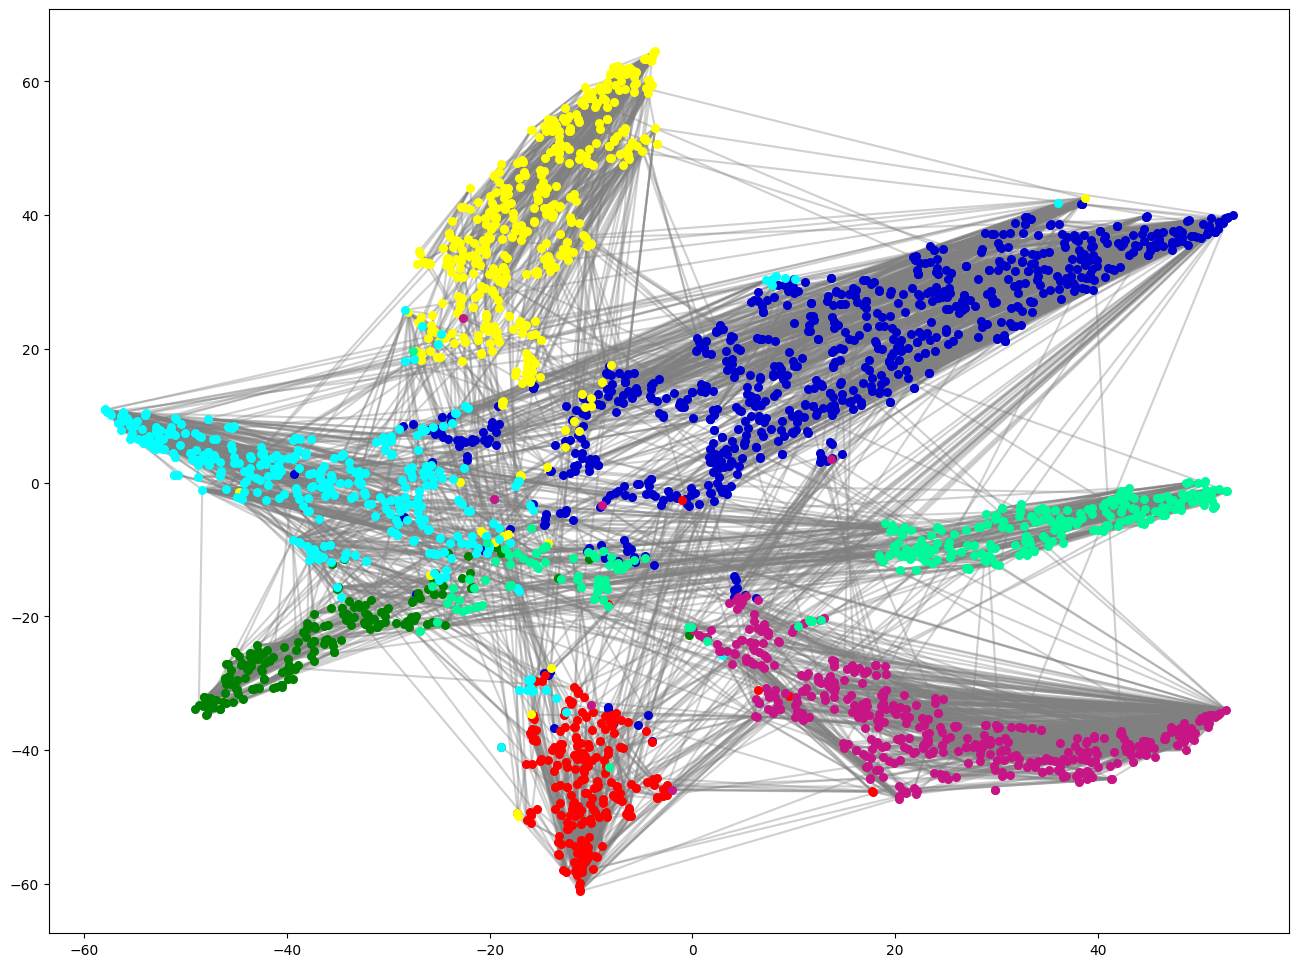

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

x = out.to('cpu').detach().numpy()
y = cora.y.to('cpu').detach().numpy()

ts = TSNE(n_components=2)
ts.fit_transform(x)
x = ts.embedding_

# pca = PCA(n_components=2) #实例化
# pca = pca.fit(x) #拟合模型
# x = pca.transform(x) #获取新矩阵

print(x.shape)

xi = []
for i in range(7):
    xi.append(x[np.where(y==i)])

colors = ['mediumblue','green','red','yellow','cyan','mediumvioletred','mediumspringgreen']
plt.figure(figsize=(16, 12))

for i in range(7):
    plt.scatter(xi[i][:,0],xi[i][:,1],s=30,color=colors[i],marker='o',alpha=1, zorder=2)

for edge in edge_index:
    start, end = edge
    plt.plot([x[start][0],x[end][0]],[x[start][1],x[end][1]],color='gray', alpha = 0.2, zorder=1)